Basis Pursuit DeNoising
=======================

This example demonstrates the use of class [admm.bpdn.BPDN](http://sporco.rtfd.org/en/latest/modules/sporco.admm.bpdn.html#sporco.admm.bpdn.BPDN) to solve the Basis Pursuit DeNoising (BPDN) problem [[15]](http://sporco.rtfd.org/en/latest/zreferences.html#chen-1998-atomic)

  $$\mathrm{argmin}_\mathbf{x} \; (1/2) \| D \mathbf{x} - \mathbf{s} \|_2^2 + \lambda \| \mathbf{x} \|_1 \;,$$

where $D$ is the dictionary, $\mathbf{x}$ is the sparse representation, and $\mathbf{s}$ is the signal to be represented. In this example the BPDN problem is used to estimate the reference sparse representation that generated a signal from a noisy version of the signal.

In [1]:
from __future__ import print_function
from builtins import input

import numpy as np

from sporco.admm import bpdn
from sporco import util
from sporco import plot
plot.config_notebook_plotting()

Configure problem size, sparsity, and noise level.

In [2]:
N = 512      # Signal size
M = 4*N      # Dictionary size
L = 32       # Number of non-zero coefficients in generator
sigma = 0.5  # Noise level

Construct random dictionary, reference random sparse representation, and test signal consisting of the synthesis of the reference sparse representation with additive Gaussian noise.

In [3]:
# Construct random dictionary and random sparse coefficients
np.random.seed(12345)
D = np.random.randn(N, M)
x0 = np.zeros((M, 1))
si = np.random.permutation(list(range(0, M-1)))
x0[si[0:L]] = np.random.randn(L, 1)

# Construct reference and noisy signal
s0 = D.dot(x0)
s = s0 + sigma*np.random.randn(N,1)

Set BPDN solver class options.

In [4]:
opt = bpdn.BPDN.Options({'Verbose': False, 'MaxMainIter': 500,
                         'RelStopTol': 1e-3, 'AutoRho': {'RsdlTarget': 1.0}})

Select regularization parameter $\lambda$ by evaluating the error in recovering the sparse representation over a logarithmicaly spaced grid. (The reference representation is assumed to be known, which is not realistic in a real application.) A function is defined that evalues the BPDN recovery error for a specified $\lambda$, and this function is evaluated in parallel by [sporco.util.grid_search](http://sporco.rtfd.org/en/latest/modules/sporco.util.html#sporco.util.grid_search).

In [5]:
# Function computing reconstruction error at lmbda
def evalerr(prm):
    lmbda = prm[0]
    b = bpdn.BPDN(D, s, lmbda, opt)
    x = b.solve()
    return np.sum(np.abs(x-x0))


# Parallel evalution of error function on lmbda grid
lrng = np.logspace(1, 2, 20)
sprm, sfvl, fvmx, sidx = util.grid_search(evalerr, (lrng,))
lmbda = sprm[0]

print('Minimum ℓ1 error: %5.2f at 𝜆 = %.2e' % (sfvl, lmbda))

Minimum ℓ1 error:  2.69 at 𝜆 = 2.98e+01


Once the best $\lambda$ has been determined, run BPDN with verbose display of ADMM iteration statistics.

In [6]:
# Initialise and run BPDN object for best lmbda
opt['Verbose'] = True
b = bpdn.BPDN(D, s, lmbda, opt)
x = b.solve()

print("BPDN solve time: %.2fs" % b.timer.elapsed('solve'))

Itn   Fnc       DFid      Regℓ1     r         s         ρ       
----------------------------------------------------------------
   0  2.27e+03  4.58e+02  6.10e+01  3.47e-01  2.80e+00  1.49e+03
   1  1.90e+03  2.86e+02  5.42e+01  1.42e-01  8.98e-01  1.49e+03
   2  1.70e+03  2.51e+02  4.87e+01  1.03e-01  7.33e-01  1.49e+03
   3  1.56e+03  2.21e+02  4.50e+01  7.85e-02  6.49e-01  1.49e+03
   4  1.45e+03  2.04e+02  4.20e+01  6.34e-02  5.98e-01  1.49e+03
   5  1.36e+03  1.91e+02  3.94e+01  5.30e-02  5.63e-01  1.49e+03
   6  1.29e+03  1.83e+02  3.71e+01  4.51e-02  5.36e-01  1.49e+03
   7  1.22e+03  1.73e+02  3.52e+01  3.92e-02  5.14e-01  1.49e+03
   8  1.16e+03  1.64e+02  3.36e+01  3.42e-02  4.91e-01  1.49e+03
   9  1.11e+03  1.55e+02  3.22e+01  3.03e-02  4.71e-01  1.49e+03
  10  9.59e+02  1.16e+02  2.83e+01  9.25e-02  4.47e-01  3.78e+02
  11  8.71e+02  9.30e+01  2.61e+01  7.69e-02  4.07e-01  3.78e+02
  12  8.37e+02  8.78e+01  2.52e+01  6.19e-02  3.24e-01  3.78e+02
  13  8.35e+02  8.43e+01 

  40  8.19e+02  8.84e+01  2.45e+01  8.45e-04  1.18e-03  1.15e+02
  41  8.19e+02  8.84e+01  2.45e+01  7.92e-04  8.23e-04  1.15e+02
----------------------------------------------------------------
BPDN solve time: 0.17s


Plot comparison of reference and recovered representations.

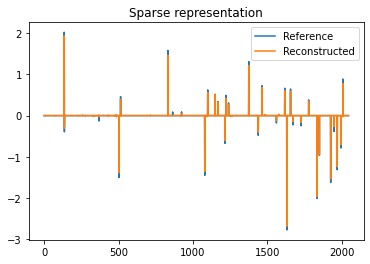

In [7]:
plot.plot(np.hstack((x0, x)), title='Sparse representation',
          lgnd=['Reference', 'Reconstructed'])

Plot lmbda error curve, functional value, residuals, and rho

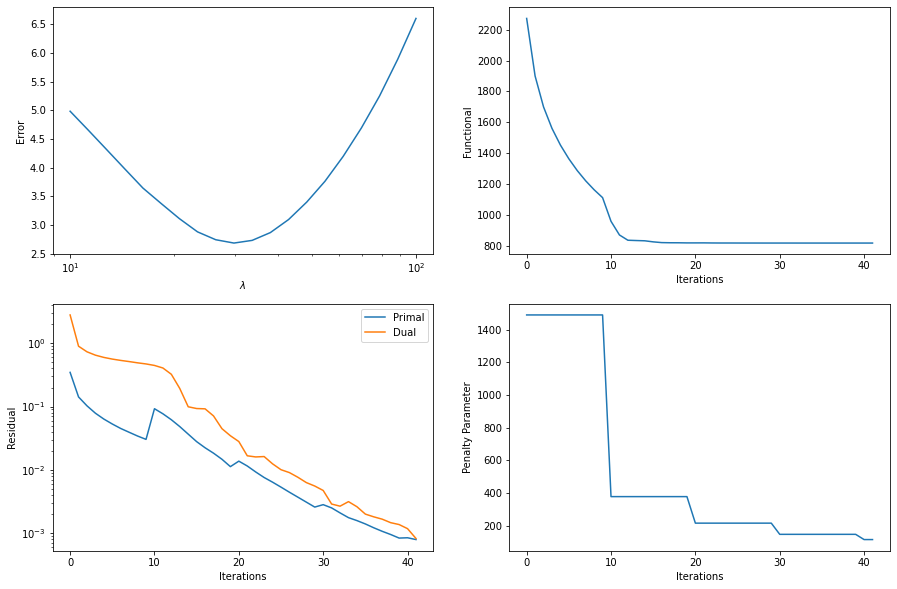

In [8]:
its = b.getitstat()
fig = plot.figure(figsize=(15, 10))
plot.subplot(2, 2, 1)
plot.plot(fvmx, x=lrng, ptyp='semilogx', xlbl='$\lambda$',
          ylbl='Error', fig=fig)
plot.subplot(2, 2, 2)
plot.plot(its.ObjFun, xlbl='Iterations', ylbl='Functional', fig=fig)
plot.subplot(2, 2, 3)
plot.plot(np.vstack((its.PrimalRsdl, its.DualRsdl)).T,
          ptyp='semilogy', xlbl='Iterations', ylbl='Residual',
          lgnd=['Primal', 'Dual'], fig=fig)
plot.subplot(2, 2, 4)
plot.plot(its.Rho, xlbl='Iterations', ylbl='Penalty Parameter', fig=fig)
fig.show()